In [15]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [37]:
# import all tensorflow and keras
import numpy as np 
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,MaxPool2D
from keras.layers import Conv2D, Reshape

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D


In [70]:
import os
import cv2
from skimage import io
from PIL import Image

In [43]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours and cut out the unnecessary backgrounds
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 3, 3)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

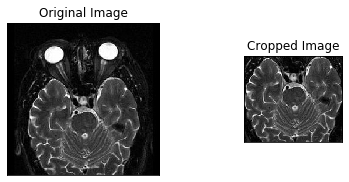

In [344]:
sample_glioma_img = cv2.imread('C:\\Users\Home\\ CAPS project\\Training\\no_tumor\\2.jpg')
crop_img = crop_brain_contour(sample_glioma_img, True)

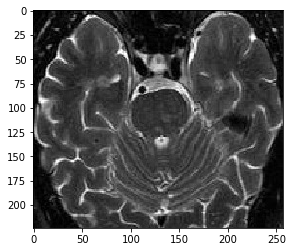

In [348]:
plt.imshow(crop_img)

In [72]:
# Define the paths in directory
train_path = 'C:\\Users\\Home\\ CAPS project\\Augmented'
test_path = 'C:\\Users\\Home\\ CAPS project\\Testing'

In [65]:
# logic to rename the files
path_dir = 'C:\\Users\\Home\\ CAPS project\\Augmented\\aug_pituitary'
all_files = os.listdir(path_dir)

cnt = 0
for images in all_files:
    old_name = os.path.join(path_dir, images)
    new_name = os.path.join(path_dir, str(cnt) + 'pp'+'.jpg')
    src = old_name
    os.rename(src,new_name)
    cnt+=1
    
    

In [297]:
def load_datar(dir_list, image_size):
   

    W = [] # Holds the image array
    m = [] # Holds the image labels
    #directory = train_path 
    image_width, image_height = image_size
    
    for directory in dir_list:
        for file in listdir(directory):
            image = cv2.imread(directory + '\\' + file)
            # cropping process
            image = crop_brain_contour(image, plot = False)
            image = cv2.resize(image, dsize = (image_width , image_height),
                               interpolation =cv2.INTER_CUBIC)
            # normalize by scaling pizels down  by 255
            image = image/255
            # convert to an array and add it to the list 
            W.append(image)
            ## Add number to the image lables array
            if directory[-5:] == 'lioma':
                m.append([1])
            elif directory[-5:] == 'gioma':
                m.append([2])
            elif directory[-9:] == 'pituitary':
                m.append([3])
            else:
                m.append([0])    
            
    # Make into a numpy array    
    W = np.array(W) 
    m = np.array(m)
        
    ## Shuffle the Data
    W,m = shuffle(W,m)

    print(f'No. of training ex. : {len(W)} images')
    print(f'W shape is: {W.shape}')
    print(f'm shape is: {m.shape}')

    return W, m



In [298]:
## Use the function to applyy cropping and load images into lists
augmented_path = 'C:\\Users\\Home\\ CAPS project\\Augmented\\'
aug_glioma = augmented_path + 'aug_glioma'
aug_meningioma = augmented_path + 'aug_meningioma'
aug_no = augmented_path + 'aug_no'
aug_pituitary = augmented_path + 'aug_pituitary' 
aug_all = augmented_path + 'aug_all'
IMG_W , IMG_H = (150,150)
## Use the function
W, m = load_datar([aug_glioma, aug_meningioma, aug_pituitary, aug_no], (IMG_W,IMG_H))


No. of training ex. : 3265 images
W shape is: (3265, 150, 150, 3)
m shape is: (3265, 1)


# Plot the Sample images 

In [335]:
def plot_images(W, m , n = 1):
## loop through all the labels in the range [0,3]
## use images instead of image
    n = int(input("How many sample Imgs plotted?"))
    for label in [0,3]:
        images = W[np.argwhere(m == label)] # matches label to image
        n_images = images[:n]
        ## generate the row and column diplay
        column_n = 10
        row_n = int(n/column_n)
        ## use plt to show picture
        plt.figure(figsize = (25,10))
        
        i = 1
        for image in n_images:
            plt.subplot(row_n, column_n, i)
            plt.imshow(image[0])
            # remove all the gridlines and ticks
            plt.tick_params(axis='both', which='both', 
                    top=False, bottom=False, left=False, right=False,
                    labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            # increment to next plot
            i +=1
        
        ## Generate the headings of the plot
        if label == 1:
            plt.suptitle("Brain Tumor : Glioma")
        elif label == 2:
            plt.suptitle("Brain Tumor: Meningioma")
        elif label == 3: 
            plt.suptitle("Brain Tumor: Pituitary")
        elif label == 0:
            plt.suptitle("Brain Tumor: None")
        
        
        #label_no = lambda label: "None" if label == 0 else("Glioma" if label ==1 else("Meningioma" if label ==2 else "Pituitary"))   
        #label_gg = lambda label: "Glioma" if label == 1 else "GG"
        #label_mm = lambda label: "Menigioma" if label == 2 else "GG"
        #label_pp = lambda label: "Pituitary" if label == 3 else "GG"
        
        #plt.suptitle(f"Brain Tumor: {label_no(label)}")
        #plt.suptitle(f"Brain Tumor: {label_gg(label)}")
        #plt.suptitle(f"Brain Tumor: {label_mm(label)}")
        #plt.suptitle(f"Brain Tumor: {label_pp(label)}")
        plt.show()

In [343]:
m = shuffle(m)
m[1]

array([2])

How many sample Imgs plotted?50


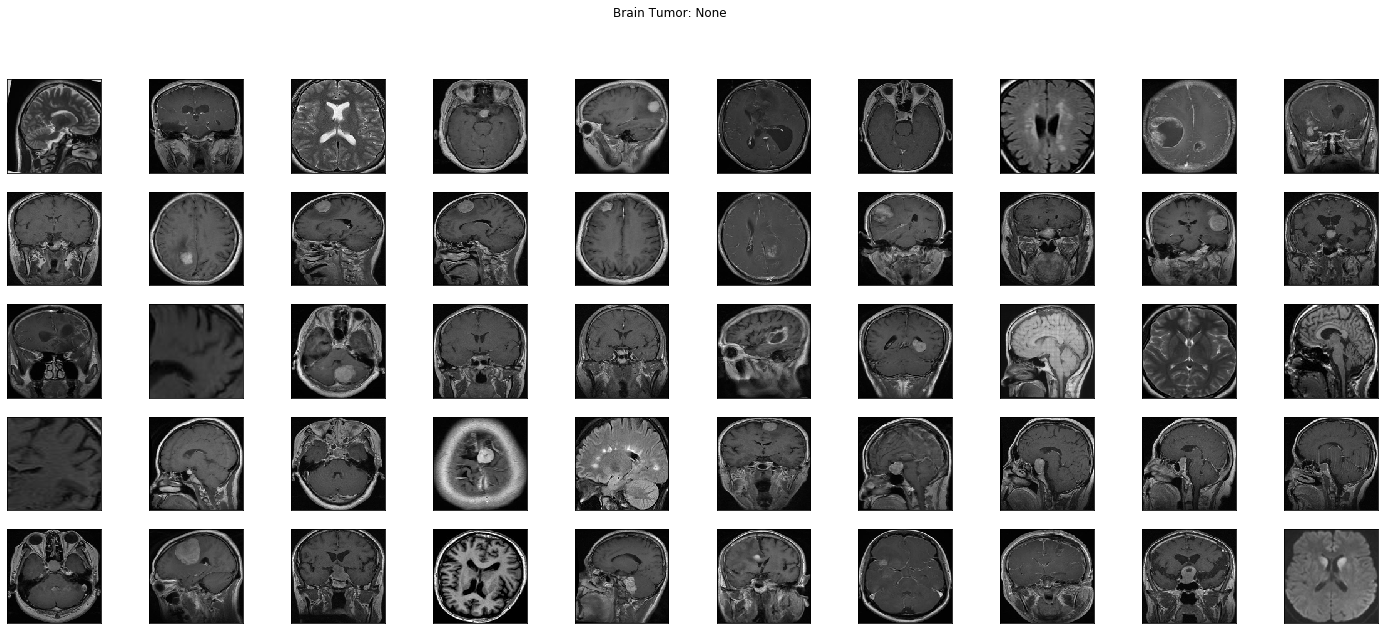

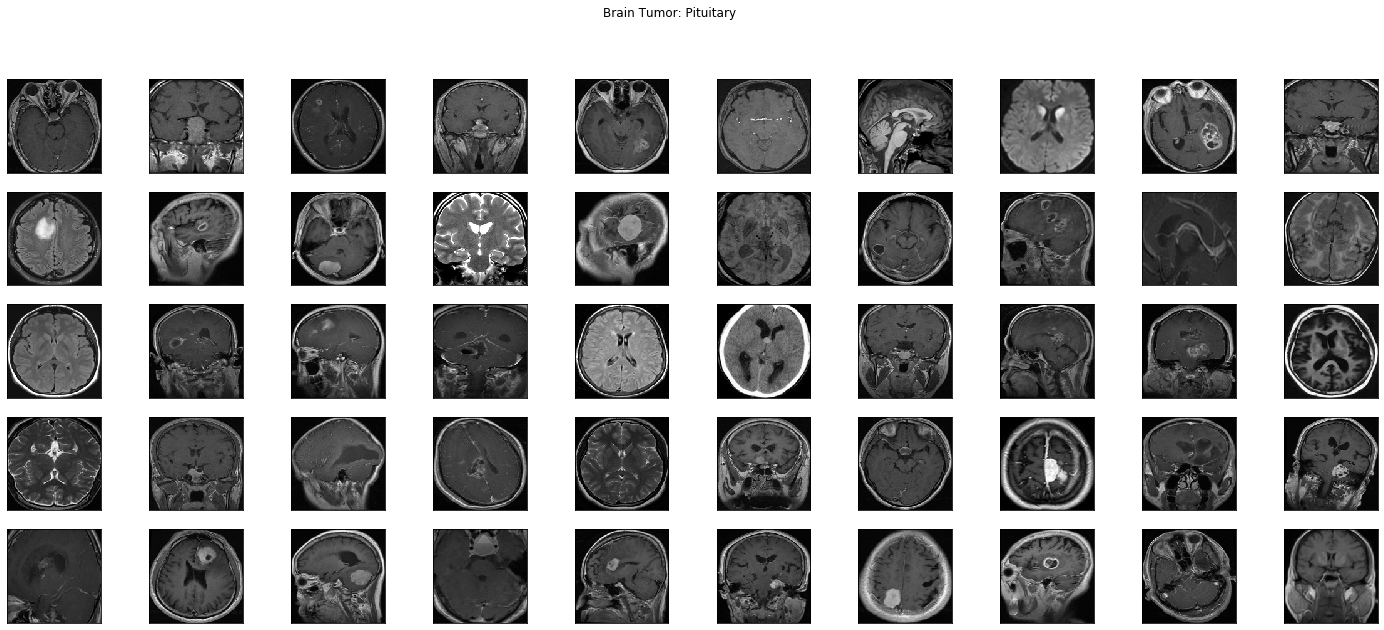

In [351]:
plot_images(W,m)

## Process the data , function splits into classes of tumors

train = ImageDataGenerator(rescale = 1/255)
validation = ImageDataGenerator(rescale = 1/255)
test = ImageDataGenerator(rescale = 1/255)
# Create batches of the train data set
train_dataset = train.flow_from_directory(train_path, target_size = (200,200),
                                         batch_size = 200, class_mode = "categorical")
test_dataset = train.flow_from_directory(test_path, target_size = (200,200),
                                         batch_size = 200, class_mode = "categorical")

traindict = train_dataset.class_indices # can also do classes instead of class_indices
print( traindict)

In [350]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical', shuffle = True)
test_set.class_indices

Found 394 images belonging to 4 classes.


{'tglioma_tumor': 0,
 'tmeningioma_tumor': 1,
 'tno_tumor': 2,
 'tpituitary_tumor': 3}

In [ ]:
def load_test(test_dir, Im)

In [150]:
# Convolutional Neural Network


# Part 2 - Building the CNN

# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))


# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=4, activation='softmax'))

# Part 3 - Training the CNN

# Compiling the CNN
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Training the CNN on the Training set and evaluating it on the Test set
cnn.fit(x = training_set, validation_data = test_set, epochs = 1)

# Part 4 - Making a single prediction
    

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
23/23 [==============================] - 26s 1s/step - loss: 0.5874 - accuracy: 0.7382 - val_loss: 0.5764 - val_accuracy: 0.7500


In [142]:
test_image = image.load_img('C:\\Users\\Home\\ CAPS project\\Testing\\tglioma_tumor\\image(3).jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
    prediction = 'Glioma'
else:
    prediction = 'no'
print(prediction)

no
